# HCU Risk Audit – Screaming Frog + Python

**Author:** Jorge J. Rolo  
**Purpose:** Detect and prioritize URLs at risk under Google’s Helpful Content Update (HCU) using Screaming Frog exports.

---

## Input
- Screaming Frog export (`Internal_All.csv` or `.xlsx`)  
- Can be a standard export or a custom one including at least:  
  - `Address`  
  - `Title 1`  
  - `Meta Description 1`  
  - `Word Count`  
  - `H1-1`  
  - `H2-1`  
  - `Status Code`  
  - `Canonical Link Element 1`  
  - `Inlinks`  
  - `Outlinks`  
  - `Indexability`  
- *(The script automatically detects English or Spanish headers and normalizes them)*

---

## Output
1. **Scored table** with `HCU_Risk` (0–100) for each URL, calculated based on signals such as:
   - Thin content
   - Low internal linking
   - Poor structure
   - Missing meta description
   - Duplicate canonical
   - Non-indexable status
2. **Risk distribution visualization** + shortlist of the **top 25 most critical URLs**.
3. **CSV export** (`hcu_scored_urls.csv`) containing all data for further analysis.
4. *(Optional)* **Base GPT prompt** to send the **top 50 URLs** for qualitative review and tailored recommendations.

---




Saving internos_html.xlsx to internos_html (1).xlsx
✅ Uploaded: internos_html (1).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


🔍 24 rows, 136 columns


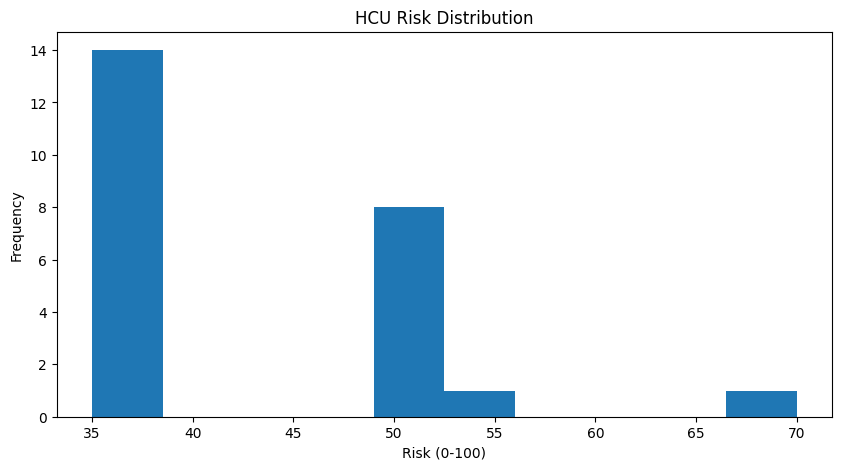

,Address,HCU_Risk,word_count,inlinks,has_h1,has_h2
11,https://jorgejrolo.com/author/admin/,70,0,19,False,False
9,https://jorgejrolo.com/project/formacion/,55,0,26,True,True
2,https://jorgejrolo.com/sxo/sxo-predictivo-como...,50,0,11,False,True
5,https://jorgejrolo.com/sxo/sxo-la-evolucion-de...,50,0,17,False,True
19,https://jorgejrolo.com/ux/posicionamiento-vs-i...,50,0,7,False,True
12,https://jorgejrolo.com/aio/que-es-query-fan-out/,50,0,34,False,True
7,https://jorgejrolo.com/aio/muvera-multi-vector...,50,0,30,False,True
21,https://jorgejrolo.com/cro/los-7-principios-ps...,50,0,7,False,True
18,https://jorgejrolo.com/aw/como-medir-el-trafic...,50,0,7,False,True
23,https://jorgejrolo.com/aio/que-es-el-model-con...,50,0,23,False,True


📂 Exported: /content/hcu_scored_urls.csv


In [21]:
# =========================================
# HCU Audit – (CSV/Excel, ES/EN)
# Author: Jorge J. Rolo
# =========================================

import os, io, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)

# ============ 1) Subida de archivo (CSV o Excel) ============
try:
    from google.colab import files  # Colab only
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {filename}")
    raw = uploaded[filename]
    data_bytes = io.BytesIO(raw)
except Exception as e:
    raise SystemExit("No file uploaded. In Colab, run this cell and upload your Screaming Frog export.")

# ============ 2) Lectura flexible (CSV o Excel) ============
def try_read(data_bytes, filename):
    name_lower = filename.lower()
    if name_lower.endswith(".csv"):
        data_bytes.seek(0)
        return pd.read_csv(data_bytes, encoding="utf-8", low_memory=False)
    elif name_lower.endswith(".xlsx"):
        try:
            import openpyxl  # ensure engine exists
        except ImportError:
            !pip -q install openpyxl
            import openpyxl
        data_bytes.seek(0)
        # Si hay varias hojas, toma la primera por defecto
        return pd.read_excel(data_bytes, sheet_name=0, engine="openpyxl")
    else:
        # Intento heurístico: primero CSV, si no, Excel
        try:
            data_bytes.seek(0)
            return pd.read_csv(data_bytes, encoding="utf-8", low_memory=False)
        except Exception:
            data_bytes.seek(0)
            try:
                import openpyxl
            except ImportError:
                !pip -q install openpyxl
                import openpyxl
            data_bytes.seek(0)
            return pd.read_excel(data_bytes, sheet_name=0, engine="openpyxl")

df = try_read(data_bytes, filename)
print(f"🔍 {df.shape[0]} rows, {df.shape[1]} columns")
df.columns = [str(c).strip() for c in df.columns]

# ============ 3) Normalización de encabezados (ES/EN) ============
# Mapa de alias → estándar esperado
ALIASES = {
    # URL
    'Address': ['Address','URL','Url','Uri','URI','Source','Dirección','Direccion','Origen'],
    # Títulos y meta
    'Title 1': ['Title 1','Title','Título 1','Titulo 1'],
    'Meta Description 1': ['Meta Description 1','Meta Description','Meta descripción 1','Meta descripcion 1'],
    # Headings
    'H1-1': ['H1-1','H1'],
    'H2-1': ['H2-1','H2'],
    # Contenido / enlaces
    'Word Count': ['Word Count','Content Words','Words','Palabras','Conteo de palabras'],
    'Inlinks': ['Inlinks','Inlinks All','Inlinks (All)','Enlaces entrantes','Enlaces internos','Entrantes'],
    'Outlinks': ['Outlinks','Outlinks All','Outlinks (All)','Enlaces salientes','Salientes'],
    # Indexabilidad / canónica
    'Indexability': ['Indexability','Indexability Status','Indexabilidad','Estado de indexabilidad'],
    'Canonical Link Element 1': [
        'Canonical Link Element 1','Canonical','Canonical URL',
        'Elemento de enlace canónico 1','URL canónica','Canonica'
    ],
}

def rename_by_alias(df, aliases):
    cols = list(df.columns)
    mapping = {}
    for std, cands in aliases.items():
        if std in cols:
            continue
        # encuentra la primera que exista
        found = next((c for c in cands if c in cols), None)
        if found:
            mapping[found] = std
    if mapping:
        df.rename(columns=mapping, inplace=True)
    return df

df = rename_by_alias(df, ALIASES)

# Rellena faltantes de columnas clave con valores seguros
for col in ['Address','Word Count','Inlinks','Outlinks','H1-1','H2-1',
            'Indexability','Meta Description 1','Canonical Link Element 1']:
    if col not in df.columns:
        # numéricas a 0; texto a vacío
        if col in ['Word Count','Inlinks','Outlinks']:
            df[col] = 0
        else:
            df[col] = ""

# ============ 4) Features seguras (tipos correctos) ============
df['word_count']   = pd.to_numeric(df['Word Count'], errors='coerce').fillna(0).astype(int)
df['inlinks']      = pd.to_numeric(df['Inlinks'], errors='coerce').fillna(0).astype(int)
df['outlinks']     = pd.to_numeric(df['Outlinks'], errors='coerce').fillna(0).astype(int)

df['has_h1']       = df['H1-1'].fillna('').astype(str).str.len().gt(0)
df['has_h2']       = df['H2-1'].fillna('').astype(str).str.len().gt(0)
df['is_indexable'] = df['Indexability'].fillna('').astype(str).str.contains(
    r'Indexable|Indexable \(.*\)|Indexable\s*', case=False, regex=True
)
df['has_meta_desc']= df['Meta Description 1'].fillna('').astype(str).str.len().gt(0)
df['has_canonical']= df['Canonical Link Element 1'].fillna('').astype(str).str.len().gt(0)

# ============ 5) Flags de riesgo ============
df['thin']         = df['word_count'] < 300
df['orphanish']    = df['inlinks'] < 5
df['no_structure'] = ~(df['has_h1'] & df['has_h2'])
df['weak_meta']    = ~df['has_meta_desc']
df['dup_canonical']= ~df['has_canonical']  # sin canónica => riesgo (puedes invertir la lógica si lo prefieres)

# ============ 6) Cálculo HCU_Risk ============
df['HCU_Risk'] = (
    df['thin'].astype(int)*25 +
    df['orphanish'].astype(int)*15 +
    df['no_structure'].astype(int)*15 +
    df['weak_meta'].astype(int)*10 +
    df['dup_canonical'].astype(int)*20 +
    (~df['is_indexable']).astype(int)*15
).clip(0, 100)

# Aviso si hay muy poca variación (para detectar “todo igual”)
if df['HCU_Risk'].nunique() <= 3:
    print("⚠️ Low variance in HCU_Risk. Check that your export contains real values for Word Count, Inlinks, Headings, etc.")

# ============ 7) Visualización + Top 25 ============
ax = df['HCU_Risk'].dropna().plot(kind='hist', bins=10)
ax.set_title('HCU Risk Distribution')
ax.set_xlabel('Risk (0-100)')
plt.show()

cols = ['Address','HCU_Risk','word_count','inlinks','has_h1','has_h2']
present = [c for c in cols if c in df.columns]
top = df.sort_values('HCU_Risk', ascending=False).head(25)
try:
    from IPython.display import display
    display(top[present])
except Exception:
    print(top[present].head(25).to_string(index=False))

# ============ 8) Export ============
out_dir = "/content"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "hcu_scored_urls.csv")
df.sort_values('HCU_Risk', ascending=False).to_csv(out_path, index=False)
print(f"📂 Exported: {out_path}")
